In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc
gc.enable()

# Read training data / Balance data for sincere and insincere questions

In [2]:
# Read training data
quora_train = pd.read_csv('data/train.csv')
# Balance the unbalanced data by downsampling Sincere questions
quora_train_sampled = quora_train[quora_train['target'] == 0].sample(100000,random_state=42)
quora_train_sampled = pd.concat([quora_train_sampled,quora_train[quora_train['target'] == 1]])
quora_train_sampled = quora_train_sampled.reset_index(drop=True)
# Shuffle the order of questions
from sklearn.utils import shuffle
quora_train_sampled = shuffle(quora_train_sampled)
quora_train_sampled.head(20)
quora_train_sampled = quora_train_sampled.reset_index(drop=True)
# Release unwanted memory
del quora_train
gc.collect()
quora_train_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180810 entries, 0 to 180809
Data columns (total 3 columns):
qid              180810 non-null object
question_text    180810 non-null object
target           180810 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.1+ MB


# Train and Test split

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(quora_train_sampled[quora_train_sampled.columns[0:-1]], quora_train_sampled[quora_train_sampled.columns[-1]], test_size=.2, stratify=quora_train_sampled[quora_train_sampled.columns[-1]])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((144648, 2), (144648,), (36162, 2), (36162,))

# Data preprocessing

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssubramanian2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssubramanian2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ssubramanian2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ssubramanian2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
def tokenize(docs):
    tokenized_docs = [word_tokenize(doc.lower()) for doc in docs]
    return tokenized_docs

def get_alpha_tokens(docs):
    alpha_tokens = [[t for t in doc if t.isalpha() == True] for doc in docs]
    return alpha_tokens

def remove_stop_words(docs,is_punc=False):
    if is_punc:  
        stopwords_en = stopwords.words('english')
    else:
        stopwords_en = stopwords.words('english').union(set(punctuation))
    tokens_wo_stop_words = [[t for t in doc if t not in stopwords_en] for doc in docs]
    return tokens_wo_stop_words

def stemmer(docs,stemmer_name="porter"):
    if stemmer_name == "snowball":
        print("Using Snowball Stemmer")
        stemmer_var = SnowballStemmer ("english", ignore_stopwords=True)
    else:
        print("Using Porter Stemmer")
        stemmer_var = PorterStemmer ()
        
    stemmed_tokens = [[stemmer_var.stem(t) for t in doc] for doc in docs]
    return stemmed_tokens

def lemmatizer(docs):
    print("Using word-net lemmatizer")
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmed_tokens = [[wordnet_lemmatizer.lemmatize(t,pos='v') for t in doc] for doc in docs]
    return lemmed_tokens
    
def text_preprocessing(docs,is_lemma=False):
    tokenized_docs = tokenize(docs)
    alpha_tokens = get_alpha_tokens(tokenized_docs)
    tokens_wo_stop_words = remove_stop_words(alpha_tokens,is_punc=True)
    if is_lemma == False:
        stem_lemma_tokens = stemmer(tokens_wo_stop_words)
    else:
        stem_lemma_tokens = lemmatizer(tokens_wo_stop_words)
    X_stem_as_string = [" ".join(x_t) for x_t in stem_lemma_tokens]
    return X_stem_as_string

In [6]:
X_train_pr = text_preprocessing(X_train['question_text'],False)
X_test_pr = text_preprocessing(X_test['question_text'],False)

Using Porter Stemmer
Using Porter Stemmer


# Feature Extraction

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

### 1. Count + TF-IDF

In [8]:
def create_tfidf_feature(ngram=(1,1)):
    tfvec = TfidfVectorizer(stop_words='english',lowercase=True,ngram_range=ngram)
    return tfvec

### 2. Polynomial features

In [9]:
def create_poly_feature():
    polynom = PolynomialFeatures()
    return polynom

### 3. SVD feature

In [10]:
def create_svd_feature(n_comp=100, random_state=42):
    svd = TruncatedSVD(n_components=n_comp, random_state=random_state)
    return svd

### 4. LDA feature

In [11]:
def create_lda_feature(n_comp=100, random_state=42):
    lda = LatentDirichletAllocation(n_components=n_comp, random_state=random_state)
    return lda

### 5. Sentiment Analysis feature

In [12]:
from sklearn.base import TransformerMixin
from nltk.sentiment.vader import SentimentIntensityAnalyzer
class SentimentAnalysis(TransformerMixin):
    
    def transform(self, X, y=None, **fit_params):
        sid = SentimentIntensityAnalyzer()
        pos = []
        neg = []
        neu = []
        for sentence in X:
            scores = sid.polarity_scores(sentence)
            pos.append(scores['pos'])
            neg.append(scores['neg'])
            neu.append(scores['neu'])
        sent_arr = np.column_stack((pos, neg, neu))
        return sent_arr
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)
    def fit(self, X, y=None, **fit_params):
        return self

def create_sentiment_feature():
    senti = SentimentAnalysis()
    return senti

### 6. Profanity feature

In [13]:
class ProfanityFilter(TransformerMixin):
    
    def transform(self, X, y=None, **fit_params):
        with open('profanity.txt', 'r') as f:
            profanity_list = f.read().splitlines()
        profanity_count = []
        for sentence in X:
            count = 0
            for word in word_tokenize(sentence):
                if word in profanity_list:
                    count += 1
            profanity_count.append(count)
        prof_arr = np.column_stack((profanity_count))
        return prof_arr.T
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)
    def fit(self, X, y=None, **fit_params):
        return self

def create_profanity_feature():
    prof = ProfanityFilter()
    return prof

# Metrics and Results

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
def print_results(y_pred,y_test,filename=None):
    cm = confusion_matrix(y_test, y_pred)
    labels = ['sincere', 'unsincere']
    df_cm = pd.DataFrame(cm, columns=labels, index=labels)
    print(df_cm)
    report = classification_report(y_test, y_pred)
    print(report)

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
def multi_scoring(y_test,y_pred):
    report = print_results(y_test, y_pred)
    print(report)
    return fbeta_score(y_test, y_pred, 1, average='macro')
class CrossValidation(TransformerMixin):
    model = None
    score = None
    def set_model(self,model):
        self.model = model
    def fit(self, X, y=None, **fit_params):
        self.score = cross_val_score(self.model, X, y, cv=3, scoring=make_scorer(multi_scoring))
        return self.score

In [47]:
def print_false_classifications(X,y_pred,y_test,n=10):
    wrong_indices = [idx for idx,(i, j) in enumerate(zip(y_pred,y_test)) if i != j]
    wrong_sentences = [X[i] for i in wrong_indices[:n]]
    actual_class = [y_test[i] for i in wrong_indices[:n]]
    return pd.DataFrame({'Sentence': wrong_sentences,'Class': actual_class,})

In [54]:
def print_true_classifications(X,y_pred,y_test,n=10):
    wrong_indices = [idx for idx,(i, j) in enumerate(zip(y_pred,y_test)) if i == j]
    wrong_sentences = [X[i] for i in wrong_indices[:n]]
    actual_class = [y_test[i] for i in wrong_indices[:n]]
    return pd.DataFrame({'Sentence': wrong_sentences,'Class': actual_class,})

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot_importance(feature_importances,n=20):
    plt.figure(figsize=(10,15))
    (pd.Series(feature_importances)
       .nlargest(n)
       .plot(kind='barh'))

# ML Models

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
class PipelineModel():
    feature_list = []
    model = None
    model_pipe = None
    
    def add_feature(self,feature_name,feature):
        self.feature_list.append((feature_name,feature))
    
    def set_model(self,model):
        self.model = model
    
    def train_pipeline(self,X_train,y_train):
        self.model_pipe = Pipeline([
            ('features', FeatureUnion(self.feature_list)),
            ('model',self.model)
        ])
        model_fit = self.model_pipe.fit(X_train,y_train)
        return model_fit
    
    def test_pipeline(self,X_test):
        y_pred = self.model_pipe.predict(X_test)
        return y_pred
    
    def cross_validate(self,X_train,y_train):
        cv_model = CrossValidation()
        cv_model.set_model(self.model)
        self.model_pipe = Pipeline([
            ('features', FeatureUnion(self.feature_list)),
            ('model',cv_model)
        ])
        model_fit = self.model_pipe.fit(X_train,y_train)
        return model_fit
        
    def hyperparam_optimize(self,X_train,y_train,hyperparams):
        self.model_pipe = Pipeline([
            ('features', FeatureUnion(self.feature_list)),
            ('model',GridSearchCV(self.model, hyperparams, cv=2, verbose=0, scoring='f1_macro'))
        ])
        best_model = self.model_pipe.fit(X_train,y_train)
        return best_model

### 1. TFIDF + SVD + POLY + SENTI + LOGISTIC

In [20]:
svd_pipeline = PipelineModel()

vectorizer = create_tfidf_feature((1,2))
svd = create_svd_feature(200)
poly = create_poly_feature()
feature_svd_pipe = Pipeline([
    ('vectorizer',vectorizer),
    ('svd',svd),
    #('polynom',poly),
])

senti = create_sentiment_feature()
feature_sentiment_pipe = Pipeline([
    ('sentiment',senti),
])

profanity = create_profanity_feature()
feature_profanity_pipe = Pipeline([
    ('profanity',profanity),
])

svd_pipeline.add_feature('svd_pipe',feature_svd_pipe)
#svd_pipeline.add_feature('senti_pipe',feature_sentiment_pipe)
#svd_pipeline.add_feature('profanity_pipe',feature_profanity_pipe)

lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
svd_pipeline.set_model(lr)

In [ ]:
model_fit = svd_pipeline.cross_validate(X_train_pr,y_train)
print("Average F1 score : ",np.mean(svd_pipeline.model_pipe.named_steps['model'].score))

In [21]:
svd_pipeline.train_pipeline(X_train_pr,y_train)
y_pred = svd_pipeline.test_pipeline(X_test_pr)
print_results(y_pred,y_test)

           sincere  unsincere
sincere      16903       3097
unsincere     3199      12963
             precision    recall  f1-score   support

          0       0.84      0.85      0.84     20000
          1       0.81      0.80      0.80     16162

avg / total       0.83      0.83      0.83     36162



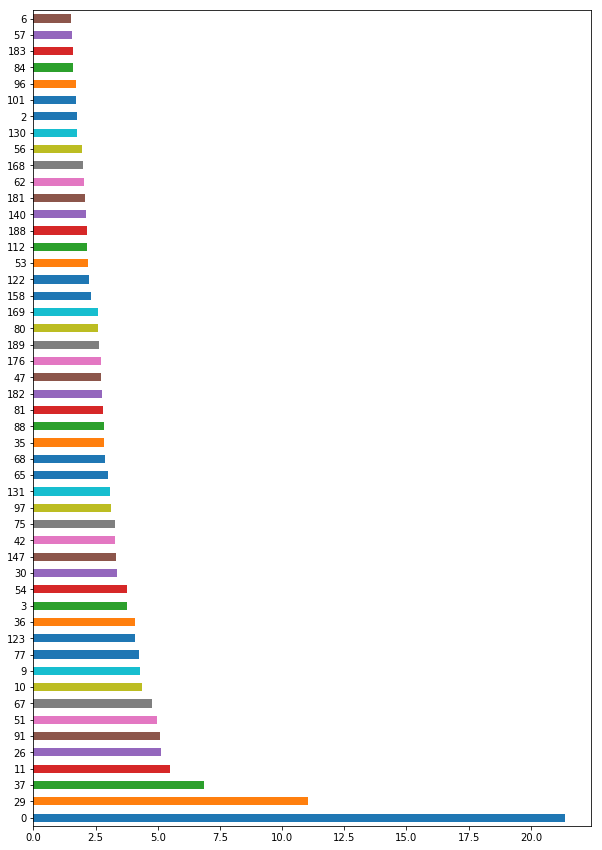

In [22]:
plot_importance(lr.coef_[0],50)

In [23]:
components = pd.DataFrame(data=svd.components_, columns=feature_svd_pipe.named_steps['vectorizer'].get_feature_names())

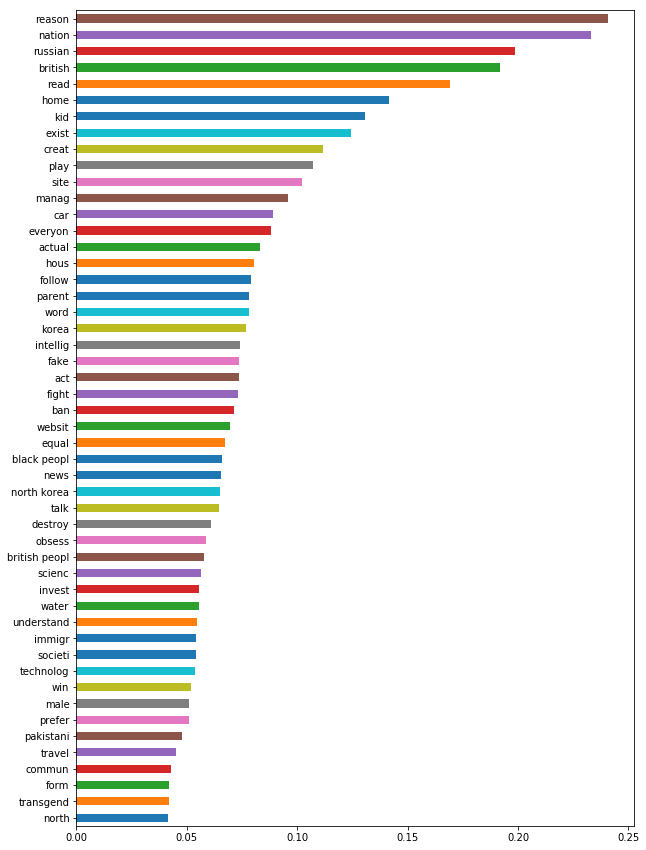

In [46]:
plt.figure(figsize=(10,15))
(components.iloc[182]).sort_values(ascending=False)[0:50].sort_values().plot.barh()

(200, 573591)
(200, 573591)
(200, 573591)
(200, 573591)
(200, 573591)
(200, 573591)
(200, 573591)
(200, 573591)
(200, 573591)
(200, 573591)


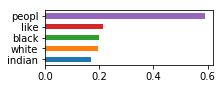

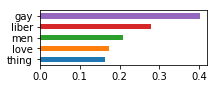

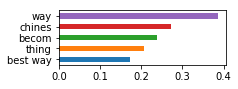

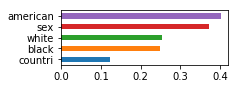

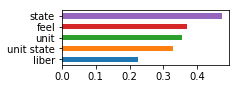

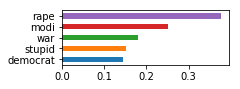

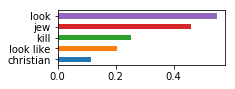

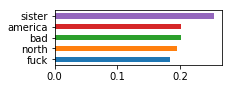

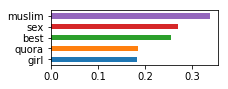

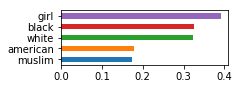

In [30]:
for i in [0,29,37,11,26,91,51,67,10,9]:
    print(components.shape)
    plt.figure(figsize=(3,1))
    (components.iloc[i]).sort_values(ascending=False)[0:5].sort_values().plot.barh()

In [51]:
y_test

123899    1
85996     0
8855      0
126940    0
127783    1
61531     1
46423     0
62313     1
88597     1
137007    1
95758     0
108335    0
43484     1
76643     0
97598     1
173033    1
1711      0
2878      1
67172     1
19747     1
126756    0
80231     1
156339    1
107699    1
18011     0
180203    1
62617     0
33675     0
134971    1
70106     1
         ..
124671    0
31696     1
106867    0
22002     1
69303     1
31983     1
5413      1
68226     0
120786    0
33928     1
117184    1
60349     0
51898     0
120129    1
86027     1
132231    0
144015    0
135948    0
101696    0
129279    0
81264     0
108275    0
369       1
60293     0
110869    1
451       1
84081     0
116213    0
65829     1
83506     1
Name: target, Length: 36162, dtype: int64

In [57]:
pd.set_option('display.max_colwidth', -1)
print_true_classifications(X_test.reset_index(drop=True)['question_text'],y_pred,y_test.reset_index(drop=True),50)

Sentence  \
0   Are Hindi-speaking north Indian migrants destroying the culture and peace of non-Hindi speaking states?                                                                                                                                                    
1   How fast can a nuclear thermal rocket engine travel to Mars?                                                                                                                                                                                               
2   What is the appearance definition in gerund?                                                                                                                                                                                                               
3   Is IKEA a respectable company like Costco or a blight like WalMart?                                                                                                                                                                                        
4   I think Donald Trump will be one of the best presidents in the history of America, he might even appear on the dollar bill or be sculpted on Mount Rushmore like in 100 year, am I wrong?                                                                  
5   What can I do to abort the pregnancy of a female?                                                                                                                                                                                                          
6   Will the ice cube left on the kitchen counter melt the fastest why?                                                                                                                                                                                        
7   Why do 11-year-old girls only have the same bored tits and holes?                                                                                                                                                                                          
8   What did nature create on its own without God's help?                                                                                                                                                                                                      
9   What is the advantage of expressing a function as a power series?                                                                                                                                                                                          
10  How can I touch my mom pusyy?                                                                                                                                                                                                                              
11  Where do broken kettles, microwaves and other home appliances go in your community? How is the network for recycling these products mantained in your community and is its sustainable and profitable?                                                     
12  What could Aquaman do against Darkseid in Justice League?                                                                                                                                                                                                  
13  How come a lot of people on social media who post about positivity, are jerks in real life?                                                                                                                                                                
14  Why do you keep publishing this "flat earth" rubbish? Such stupidity should be just dumped aside. Not argued by otherwize intelligent people.                                                                                                              
15  Are there any discrimination done to person who has converted from another faith to Islam by another Muslim brothers?                           

In [ ]:
del svd_pipeline
del components
gc.collect()

### 2. TFIDF + LDA + POLY + SENTI + LOGISTIC

In [ ]:
lda_pipeline = PipelineModel()

vectorizer = create_tfidf_feature((1,3))
lda = create_lda_feature()
poly = create_poly_feature()
feature_lda_pipe = Pipeline([
    ('vectorizer',vectorizer),
    ('lda',lda),
    ('polynom', poly),
])

senti = create_sentiment_feature()
feature_sentiment_pipe = Pipeline([
    ('sentiment',senti),
])

profanity = create_profanity_feature()
feature_profanity_pipe = Pipeline([
    ('profanity',profanity),
])

lda_pipeline.add_feature('lda_pipe',feature_lda_pipe)
lda_pipeline.add_feature('senti_pipe',feature_sentiment_pipe)
lda_pipeline.add_feature('profanity_pipe',feature_profanity_pipe)

lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
lda_pipeline.set_model(lr)

lda_pipeline.train_pipeline(X_train_pr,y_train)
y_pred = lda_pipeline.test_pipeline(X_test_pr)
print_results(y_pred,y_test)

In [ ]:
del lda_pipeline
gc.collect()

### 3. TFIDF + SVD + POLY + SENTI + DECISION TREE

In [ ]:
dtree_pipeline = PipelineModel()

vectorizer = create_tfidf_feature((1,2))
svd = create_svd_feature(200)
poly = create_poly_feature()
feature_dtree_pipe = Pipeline([
    ('vectorizer',vectorizer),
    ('svd',svd),
    #('polynom', poly),
])

senti = create_sentiment_feature()
feature_sentiment_pipe = Pipeline([
    ('sentiment',senti),
])

profanity = create_profanity_feature()
feature_profanity_pipe = Pipeline([
    ('profanity',profanity),
])

dtree_pipeline.add_feature('dtree_pipe',feature_dtree_pipe)
dtree_pipeline.add_feature('senti_pipe',feature_sentiment_pipe)
dtree_pipeline.add_feature('profanity_pipe',feature_profanity_pipe)

dtree = DecisionTreeClassifier(random_state=0, criterion='entropy',max_depth=70,min_samples_leaf=60)
dtree_pipeline.set_model(dtree)

In [ ]:
dtree_pipeline.hyperparam_optimize(X_train_pr,y_train,param_grid_dtree)
print(dtree_pipeline.model_pipe.named_steps['model'].best_estimator_)
print(dtree_pipeline.model_pipe.named_steps['model'].best_score_)

In [ ]:
model_fit = dtree_pipeline.cross_validate(X_train_pr,y_train)
print("Average F1 score : ",np.mean(dtree_pipeline.model_pipe.named_steps['model'].score))

In [ ]:
dtree_pipeline.train_pipeline(X_train_pr,y_train)
y_pred = dtree_pipeline.test_pipeline(X_test_pr)
print_results(y_pred,y_test)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
(pd.Series(dtree.feature_importances_)
   .nlargest(20)
   .plot(kind='barh'))

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(dtree,out_file='tree.dot')

In [ ]:
del dtree_pipeline
gc.collect()

### Random Forest

In [ ]:
rf_pipeline = PipelineModel()

vectorizer = create_tfidf_feature((1,2))
svd = create_svd_feature(200)
poly = create_poly_feature()
feature_rf_pipe = Pipeline([
    ('vectorizer',vectorizer),
    ('svd',svd),
    ('polynom', poly),
])

senti = create_sentiment_feature()
feature_sentiment_pipe = Pipeline([
    ('sentiment',senti),
])

profanity = create_profanity_feature()
feature_profanity_pipe = Pipeline([
    ('profanity',profanity),
])

rf_pipeline.add_feature('rf_pipe',feature_rf_pipe)
rf_pipeline.add_feature('senti_pipe',feature_sentiment_pipe)
rf_pipeline.add_feature('profanity_pipe',feature_profanity_pipe)

rf = RandomForestClassifier(random_state=0, criterion='entropy',max_depth=100,min_samples_leaf=60,max_features='sqrt')
rf_pipeline.set_model(rf)

rf_pipeline.train_pipeline(X_train_pr,y_train)
y_pred = rf_pipeline.test_pipeline(X_test_pr)
print_results(y_pred,y_test)

### K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_pipeline = PipelineModel()

vectorizer = create_tfidf_feature((1,3))
svd = create_svd_feature()
poly = create_poly_feature()
feature_knn_pipe = Pipeline([
    ('vectorizer',vectorizer),
    ('svd',svd),
])

senti = create_sentiment_feature()
feature_sentiment_pipe = Pipeline([
    ('sentiment',senti),
])

profanity = create_profanity_feature()
feature_profanity_pipe = Pipeline([
    ('profanity',profanity),
])

knn_pipeline.add_feature('knn_pipe',feature_knn_pipe)
knn_pipeline.add_feature('senti_pipe',feature_sentiment_pipe)
knn_pipeline.add_feature('profanity_pipe',feature_profanity_pipe)

knn = KNeighborsClassifier(5)
knn_pipeline.set_model(knn)

knn_pipeline.train_pipeline(X_train_pr,y_train)
y_pred = knn_pipeline.test_pipeline(X_test_pr)
print_results(y_pred,y_test)

In [ ]:
del knn_pipeline
gc.collect()

In [ ]:
### Logistic regression hyperparameter space
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
# Create hyperparameter options
hyperparameters_lr = dict(C=C, penalty=penalty)

### Random Forest hyperparameter space
param_grid_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

### Decision tree hyperparameter space
param_grid_dtree = {
    'max_depth': [100, 200, 300],
    'min_samples_leaf': [20, 40, 60],
}